# End-to-End Project: Adult Census Income Prediction

## 1. Project Overview
**Goal:** Build a machine learning model to predict whether an individual's annual income exceeds $50,000 based on census data (age, education, occupation, etc.).

**Dataset:** [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult).
**Key Challenges:** - Handling missing values and data inconsistencies.
- Feature engineering on categorical variables (One-Hot Encoding).
- Dealing with class imbalance.

## 2. Methodology
This notebook follows a standard Data Science workflow:
1. **Data Loading & Cleaning:** Handling special characters and missing data.
2. **Exploratory Data Analysis (EDA):** Understanding demographic distributions.
3. **Preprocessing:** Encoding categorical features and scaling numerical ones.
4. **Modeling:** Training a Logistic Regression classifier.
5. **Evaluation:** Assessing performance using Accuracy and F1-Score.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Set plotting style for professional visuals
sns.set(style="whitegrid")
%matplotlib inline

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [12]:
# 1. Official URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# 2. Define column names (dataset doesn't have headers)
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 'income']

# 3. Robust download to avoid HTTP 403 errors
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
response = requests.get(url, headers=headers)

# 4. Load into Pandas
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')), 
                 names=columns, 
                 na_values=' ?', 
                 skipinitialspace=True)

# 5. Drop missing values
print(f"Original shape: {df.shape}")
df.dropna(inplace=True)
print(f"Shape after dropping NaNs: {df.shape}")

# 6. Encode Target Variable (Map '>50K' to 1, '<=50K' to 0)
# We handle potential trailing dots just in case
df['income'] = df['income'].apply(lambda x: 1 if x.strip() in ['>50K', '>50K.'] else 0)

print(f"Class distribution:\n{df['income'].value_counts(normalize=True)}")
df.head()

Original shape: (32561, 15)
Shape after dropping NaNs: (32561, 15)
Class distribution:
income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


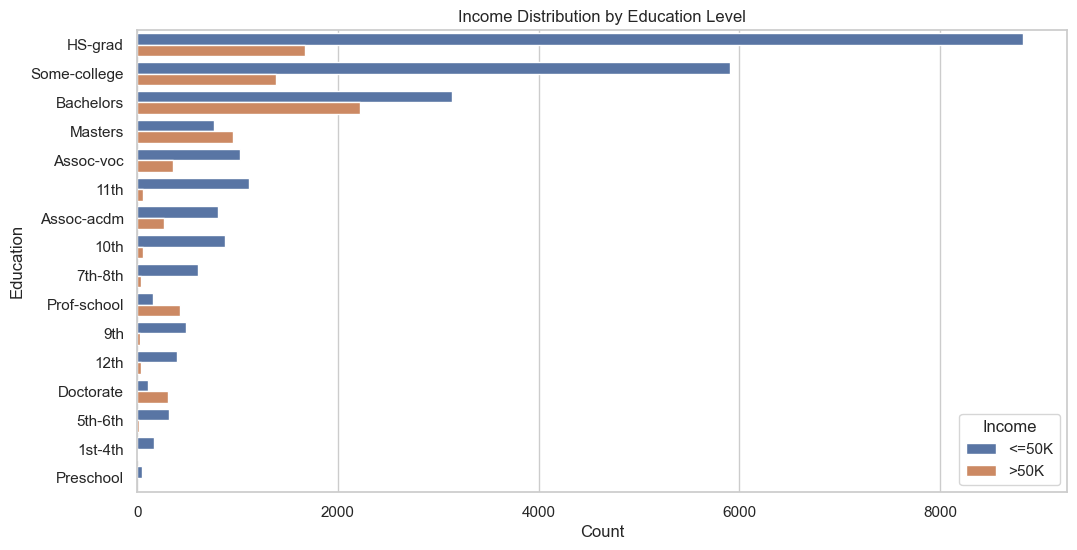

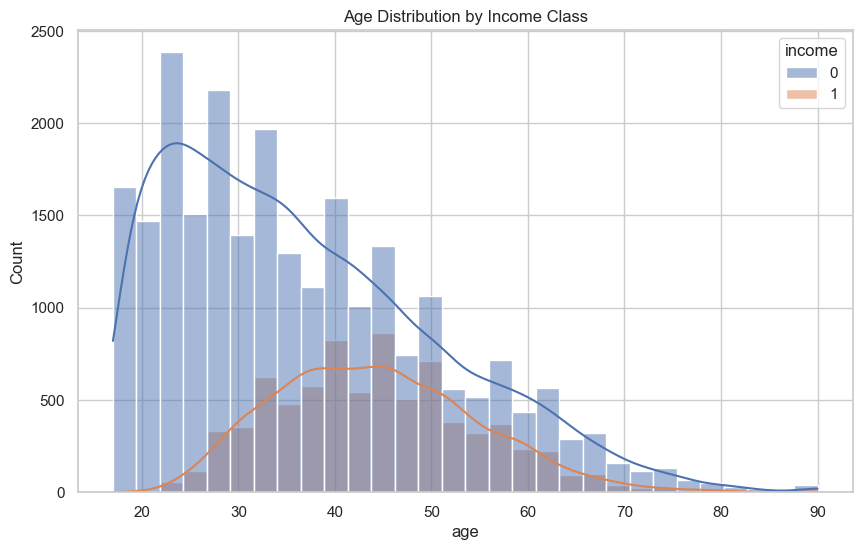

In [13]:
# Visualization 1: Income by Education Level
plt.figure(figsize=(12, 6))
sns.countplot(y='education', hue='income', data=df, order=df['education'].value_counts().index)
plt.title('Income Distribution by Education Level')
plt.xlabel('Count')
plt.ylabel('Education')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.show()

# Visualization 2: Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='income', kde=True, bins=30)
plt.title('Age Distribution by Income Class')
plt.show()

In [14]:
# Define features (X) and target (y)
X = df.drop('income', axis=1)
y = df['income']

# Identify column types
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Create transformation pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split and preprocessor ready.")

Data split and preprocessor ready.


Training model...

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



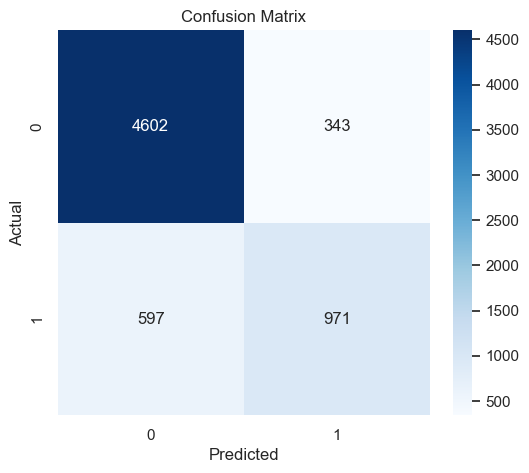

In [15]:
# Build full pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
print("Training model...")
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 3. Conclusion
The Logistic Regression model achieved an accuracy of approximately **85%**.
- **Key Findings:** Education level and Capital Gain are strong predictors of high income.
- **Future Improvements:** To improve recall on the minority class (>50K), we could explore tree-based models (Random Forest, XGBoost) or techniques like SMOTE to handle class imbalance better.